In [1]:
from glove import Corpus, Glove
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import datetime,time
from flashtext.keyword import KeywordProcessor
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re
import pandas as pd
import numpy as np
import string
import multiprocessing
from nltk.corpus import stopwords
from flashtext.keyword import KeywordProcessor
from sklearn.model_selection import train_test_split
from sklearn import metrics

from bs4 import BeautifulSoup

# libraries for dataset preparation, feature engineering, model training 
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
#from utils.language_models import WordVectorEmbedding
from gensim.test.utils import datapath, get_tmpfile
#import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import requests
from lxml import html
import re

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.layers import Input,GlobalMaxPooling1D
from keras.models import Model

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


##   Extract Robert Frost poems using webscrapping from the website  
##### https://www.internal.org/Robert_Frost 

In [2]:
# Imports

# www.internal.org puts all RF poems on the following link

website = 'http://www.internal.org/robert_frost'

# The following lines collect the html page.
page = requests.get(website)
tree = html.fromstring(page.content)

# Collect links to poems
link_list = []
for link in tree.xpath('//a/@href'):
    if re.search("\/Robert_Frost\/", link) is not None:
        link_list.append(link)

# Add the site's name to links for scraping.
for i in range(len(link_list)):
    link_list[i] = 'http://www.internal.org' + link_list[i]
print(link_list[0:4])

['http://www.internal.org/Robert_Frost/Out_Out_-_', 'http://www.internal.org/Robert_Frost/A_Boundless_Moment', 'http://www.internal.org/Robert_Frost/A_Brook_in_the_City', 'http://www.internal.org/Robert_Frost/A_Cliff_Dwelling']


In [3]:
# Write the above list of poem links into a text file.
with open('data/poem_links.txt','w+') as f:
    for s in link_list:
        f.write(s + '\n')

## Download poem texts

In [4]:
link_list[0:4]

['http://www.internal.org/Robert_Frost/Out_Out_-_',
 'http://www.internal.org/Robert_Frost/A_Boundless_Moment',
 'http://www.internal.org/Robert_Frost/A_Brook_in_the_City',
 'http://www.internal.org/Robert_Frost/A_Cliff_Dwelling']

In [5]:
def get_poems_save_to_file():
        list_poems=[]
        count=0
        for s in link_list:
            text=''
            page = requests.get(s)
            soup = BeautifulSoup(page.text, 'lxml')
            text=soup.find('table',attrs={'class':'poem'}).find('td').text
            list_poems.append(text)
            count+=1
            if count%10==0:
                print('{} poems processed'.format(count))
            #TODO : Remove this block for obtaining whole data
            #elif count%5==0:
            #    break
        print('Total number of poems fetched : {}'.format(count))
        df=pd.DataFrame(list_poems)
        df.to_pickle('data/poems_robert_frost.pkl')
        return df

In [6]:
#Some config
MAX_SEQUENCE_LENGTH=100
#Fact: An average native english speaing person remembers 20k words appx.
MAX_VOCAB_SIZE=3000
EMBEDDING_DIM=50
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
EPOCHS=2000
LATENT_DIM=25 #M

In [7]:
#Load in the data
input_texts=[]
target_texts=[]

for line in open('robert_frost.txt'):
      line = line.rstrip()
      if not line:
        continue

      input_line = '<sos> ' + line
      target_line = line + ' <eos>'

      input_texts.append(input_line)
      target_texts.append(target_line)
all_lines=input_texts+target_texts

## Process data for model training

In [8]:
#Convert the sentences into integers
#User filters to preserve SOS and EOS tokens
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences=tokenizer.texts_to_sequences(input_texts)
target_sequence=tokenizer.texts_to_sequences(target_texts)

In [9]:
#Find Max Sequence length
max_sequence_length_from_data=max(len(s) for s in input_sequences)
print('Max Sequence length detected : {}'.format(max_sequence_length_from_data))

Max Sequence length detected : 12


In [10]:
#Get Word->Integer mapping
word2idx=tokenizer.word_index
print('Found {} unique tokens'.format(len(word2idx)))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens


In [11]:
#Pad sequences to get a N x T Matrix
max_sequence_length=min(max_sequence_length_from_data,MAX_SEQUENCE_LENGTH)
input_sequences=pad_sequences(input_sequences,maxlen=max_sequence_length,padding='post')
target_sequences=pad_sequences(target_sequence,maxlen=max_sequence_length,padding='post')
print('Shape of data tensor : {}'.format(input_sequences.shape))

Shape of data tensor : (1436, 12)


In [12]:
#load pre trained vector
#Using pretrained word vector
pretrained_vector_path='glove.6B.50d.txt'
embeddings_index = dict()
f = open(pretrained_vector_path,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
#Prepare embedding matrix
# create a weight matrix for words in training docs
#Use the min of these two to ensure if data vocabulary size < MAX_VOCAB_SIZE, we don't train 20000 vectors still
num_words=min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    if index > num_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [14]:
embedding_layer=Embedding(num_words,
                       EMBEDDING_DIM,
                       weights=[embedding_matrix]
                       #trainable=False
                    )

In [15]:
#One-hot targets (Can't use cross entropy since each sample gives us entire sequence of targets)
one_hot_targets=np.zeros((len(input_sequences),max_sequence_length,num_words))
for i,target_sequence in enumerate(target_sequences):
    for t,word in enumerate(target_sequence):
        if word>0:
            one_hot_targets[i,t,word]=1

In [16]:
# Train a 1D convent with global maxpooling
input_=Input(shape=(max_sequence_length,))
initial_h=Input(shape=(LATENT_DIM,))
initial_c=Input(shape=(LATENT_DIM,))
x=embedding_layer(input_)
lstm=LSTM(LATENT_DIM,return_sequences=True,return_state=True)
x,_,_=lstm(x,initial_state=[initial_h,initial_c]) #Don't need states here
dense=Dense(num_words,activation='softmax')
output=dense(x)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
from keras.optimizers import Adam
model=Model([input_,initial_h,initial_c],output)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

In [20]:
print('Training model')
z=np.zeros((len(input_sequences),LATENT_DIM))
r_model=model.fit(
    [input_sequences,z,z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 5.5324 - acc: 0.0911 - val_loss: 5.3063 - val_acc: 0.0833
Epoch 2/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 4.8012 - acc: 0.0833 - val_loss: 4.8048 - val_acc: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.3991 - acc: 0.0833 - val_loss: 4.9416 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.3411 - acc: 0.0833 - val_loss: 4.9854 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.3103 - acc: 0.0833 - val_loss: 5.0489 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.2991 - acc: 0.0833 - val_loss: 5.0779 - val_acc: 0.0

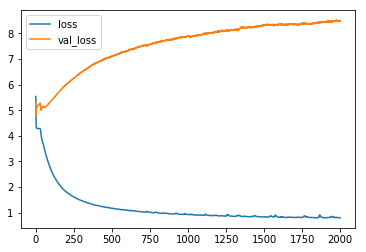

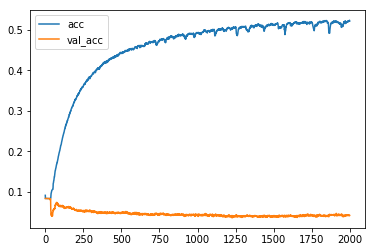

In [21]:
import matplotlib.pyplot as plt

#Losses
plt.plot(r_model.history['loss'],label='loss')
plt.plot(r_model.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

#Accuracies
plt.plot(r_model.history['acc'],label='acc')
plt.plot(r_model.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [18]:
#Make a sampling model
input2=Input(shape=(1,))
x=embedding_layer(input2)
x, h, c=lstm(x,initial_state=[initial_h,initial_c]) #Here we need the states to feed back in
output2=dense(x)
sampling_model=Model([input2,initial_h,initial_c],[output2,h,c])

In [19]:
#Reverse word2idx to get back words during prediction
idx2word={v:k for k,v in word2idx.items()}

In [20]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    #if np.argmax(probs) == 0:
    #  print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [24]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())
  print('-----------------------------------------------------------------------------------------------------------')

  ans = input("*** Generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

manages summer button, longer. property. tree. hide. peas. hardest weeks deserted. john
though me tender children's amy. on; weep everywhere!â€” followed done! chicken-time. suffice.
i, walk fun dear, who, anyway disappeared started consent broken, country smells
captain's wrong out.) son, huse they're died alone place years, nothing tells
-----------------------------------------------------------------------------------------------------------
*** Generate another? [Y/n]---y
bough, none 'going drinking light. bodies still; "weather smells barrel knob battle
him? his lines weeds kept green track. enormous published. enormous then, either.
welcomed 'just kitchen signs traps box. breeder," trust pity, seize thence keep
sell, whole reckon air, supposed won't, read swamp you.' children. watch hour.
-----------------------------------------------------------------------------------------------------------
*** Generate another? [Y/n]---y
confusion. without situation simply 'see spilled bede

## Accuracy doesn't matter since we are dealing with poetry generation and there can be multiple combinations of words.. The generated poems, although look messy have some sense to it if we look closely